<a href="https://colab.research.google.com/github/LeslyVictoria2/CSST106-CS4B/blob/main/4B_VICTORIA_MP5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CSST106 - Perception and Computer Vision**
##**MACHINE PROBLEM 5**
###**Lesly-Ann B. Victoria from BSCS-4B**

#### **TASK 1: Model Loading**

In [11]:
#Import Libraries.
import cv2
import numpy as np

#Paths to YOLO configuration, weights, and COCO names file.
cfg_path = '/content/drive/MyDrive/YOLOv4/yolov4.cfg'
weights_path = '/content/drive/MyDrive/YOLOv4/yolov4.weights'
names_path = '/content/drive/MyDrive/YOLOv4/coco.names'

#Load COCO class labels.
with open(names_path, 'r') as f:
    classes = [line.strip() for line in f.readlines()]

#Load YOLO model with OpenCV.
net = cv2.dnn.readNetFromDarknet(cfg_path, weights_path)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

#Get the names of YOLO's output layers.
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

#### **TASK 2: Image Input**

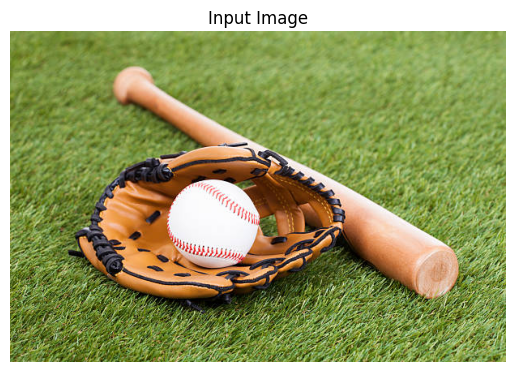

In [12]:
#Import Libraries.
import matplotlib.pyplot as plt

#Load the image.
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found at path: {image_path}")
    return image

#Image path.
image_path = '/content/drive/MyDrive/YOLOv4/y4.jpg'
image = load_image(image_path)

#Display the image.
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Input Image')
plt.show()

#### **TASK 3: Object Detection**

In [13]:
def detect_objects_yolo(image):
    height, width = image.shape[:2]

    #Preprocess the image for YOLO.
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)

    #Run forward pass to get detection results.
    detections = net.forward(output_layers)

    #Initialize lists for detected bounding boxes, confidences, and class IDs.
    boxes = []
    confidences = []
    class_ids = []

    #Process each detection.
    for output in detections:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                #Scale bounding box coordinates to original image size.
                box = detection[0:4] * np.array([width, height, width, height])
                (center_x, center_y, w, h) = box.astype("int")
                x = int(center_x - (w / 2))
                y = int(center_y - (h / 2))

                #Append to lists.
                boxes.append([x, y, int(w), int(h)])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    return boxes, confidences, class_ids

#### **TASK 4: Visualization**

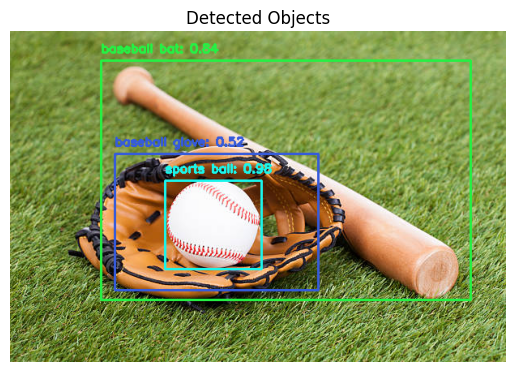

In [14]:
#Generate random colors for each class.
np.random.seed(42)
colors = np.random.randint(0, 255, size=(len(classes), 3), dtype='uint8')

def detect_and_draw_boxes(image, confidence_threshold=0.5, nms_threshold=0.4):
    height, width = image.shape[:2]

    #Preprocess the image for YOLO.
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)

    #Run forward pass to get detection results.
    detections = net.forward(output_layers)

    #Initialize lists for detected bounding boxes, confidences, and class IDs.
    boxes = []
    confidences = []
    class_ids = []

    #Process each detection.
    for output in detections:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > confidence_threshold:
                #Scale bounding box coordinates to original image size.
                box = detection[0:4] * np.array([width, height, width, height])
                (center_x, center_y, w, h) = box.astype("int")
                x = int(center_x - (w / 2))
                y = int(center_y - (h / 2))

                #Append to lists.
                boxes.append([x, y, int(w), int(h)])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    #Apply Non-Maximum Suppression (NMS).
    indices = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=confidence_threshold, nms_threshold=nms_threshold)

    #Draw bounding boxes and labels on the image.
    for i in indices.flatten():
        x, y, w, h = boxes[i]
        color = [int(c) for c in colors[class_ids[i]]]
        label = f"{classes[class_ids[i]]}: {confidences[i]:.2f}"

        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return image

#Detect objects and draw boxes.
output_image = detect_and_draw_boxes(image.copy())

#Display the output image.
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Detected Objects")
plt.show()

#### **TASK 5: Testing**

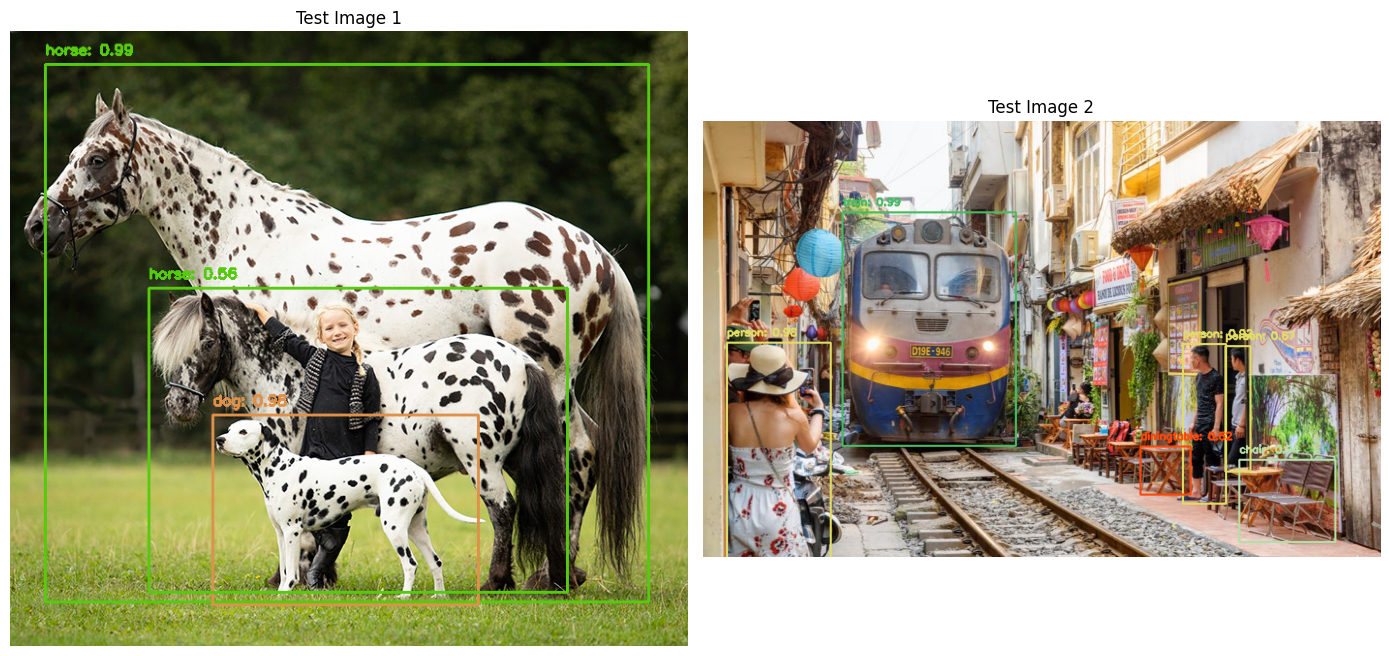

In [19]:
#List of image paths for testing.
image_paths = [
    '/content/drive/MyDrive/YOLOv4/y1.jpg',
    '/content/drive/MyDrive/YOLOv4/y2.jpg',
]

#Visualization for multiple images.
plt.figure(figsize=(14, 12))
for i, path in enumerate(image_paths, 1):
    test_image = load_image(path)
    output_image = detect_and_draw_boxes(test_image.copy())

    #Plot the image with detections.
    plt.subplot(1, len(image_paths), i)
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Test Image {i}")

plt.tight_layout()
plt.show()

#### **TASK 6: Performance Analysis**

In [21]:
#Import Libraries.
import time

#Function to run detection and measure performance.
def analyze_performance(image_paths):
    total_time = 0
    total_detections = 0
    results = []

    for path in image_paths:
        image = load_image(path)

        #Measure detection time.
        start_time = time.time()
        boxes, confidences, class_ids = detect_objects_yolo(image)
        detection_time = time.time() - start_time

        #Count detections.
        num_detections = len(boxes)

        #Update total metrics.
        total_time += detection_time
        total_detections += num_detections

        #Store results for this image.
        results.append({
            'image_path': path,
            'detection_time': detection_time,
            'num_detections': num_detections
        })

        print(f"Image: {path}")
        print(f"  Detection Time: {detection_time:.4f} seconds")
        print(f"  Number of Detections: {num_detections}")
        print("="*40)

    #Calculate averages.
    avg_time = total_time / len(image_paths)
    avg_detections = total_detections / len(image_paths)

    print("\nPerformance Summary:")
    print(f"Average Detection Time: {avg_time:.4f} seconds")
    print(f"Average Number of Detections: {avg_detections:.2f}")

    return results, avg_time, avg_detections

#Test images.
image_paths = [
    '/content/drive/MyDrive/YOLOv4/y4.jpg',
    '/content/drive/MyDrive/YOLOv4/y1.jpg',
    '/content/drive/MyDrive/YOLOv4/y2.jpg'
]

#Run performance analysis.
results, avg_time, avg_detections = analyze_performance(image_paths)

Image: /content/drive/MyDrive/YOLOv4/y4.jpg
  Detection Time: 1.5373 seconds
  Number of Detections: 14
Image: /content/drive/MyDrive/YOLOv4/y1.jpg
  Detection Time: 1.5113 seconds
  Number of Detections: 16
Image: /content/drive/MyDrive/YOLOv4/y2.jpg
  Detection Time: 1.4676 seconds
  Number of Detections: 26

Performance Summary:
Average Detection Time: 1.5054 seconds
Average Number of Detections: 18.67
